# Laboratorio 4. Práctica 1 - Algoritmo Genético con mutaciones
## Preparación de entorno
### Gonzalo de las Heras
### Jorge de la Fuente

#### Importar librerías de código

In [1042]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import random

from math import e
from time import time

#### Parámetros del algoritmo genérico

In [1043]:
Target = "ANIMUANIMUANIMUANIMUANIMU" 
NPOB = 400
NGEN = 3000
Q = 0.98
NRES = 25
NSAMPLE = 50

In [1044]:
# No tocar
ITAR_TARGET = len(Target)
T_Inicio = 0
T_Final = 0
T_TOTAL = 0
Parada = 0
Terminar_Evolucion = 0

Stats_num_coincidencias_max = np.zeros(1) 
Stats_num_coincidencias_max_porcentaje = np.zeros(1) 
Stats_num_coincidencias_medio = np.zeros(1)  
Stats_num_coincidencias_medio_porcentaje = np.zeros(1) 
Stats_num_targets = np.zeros(1) 
Stats_num_targets_porcentaje = np.zeros(1) 

#### Variables globales

In [1045]:
Alfabeto = np.array(["A","B","C","D","E","F","G","H","I",
                     "J","K","L","M","N","Ñ","O","P","Q",
                     "R","S","T","U","V","W","X","Y","Z"," "])
Poblacion = None
Fitness = np.zeros(NPOB)
Coincidencias = np.zeros(NPOB)
Generacion_Actual = 1
Num_Coincidencias_Max = 0

#### Funciones auxiliares

In [1046]:
def ImprimirPorcentajePoblacion():
    porcentaje = 20
    num_individuos_a_imprimir = int(round(20 * NPOB / 100, 0))
    posiciones_aleatoras = random.sample(range(0, NPOB - 1), num_individuos_a_imprimir)
    print("= Muestra de " + str(20) + "% de individuos (" + str(num_individuos_a_imprimir) + "):")
    print("=====================================")
    for i in range (0, num_individuos_a_imprimir):
        print("= #" + str(i + 1) + ": '" + ImprimirCromosoma(Poblacion[posiciones_aleatoras[i]]) + "'")

In [1047]:
def ImprimirPoblacion():
    print("==================================================")
    for i in range(0, NPOB):
        print("#" + str(i) + ": '" + ImprimirCromosoma(Poblacion[i]) + "'")

In [1048]:
def GenerarPoblacion():    
    # Números aleatorios
    poblacion_numeros = np.random.randint(0, len(Alfabeto), size=len(Target) * NPOB)
    
    # Creación del array de la poblacion con caracter "_"
    poblacion = np.array(['_' for _ in range(len(Target) * NPOB)])
    
    # Cambiamos los números por las letras del alfabeto
    for i in range(0, len(Target) * NPOB):
        letra = Alfabeto[poblacion_numeros[i]].encode('utf8', 'ignore').decode('utf8')
        poblacion[i] = letra
        
    # Devuelve la array de la población con el shape correcto
    return poblacion.reshape(NPOB, len(Target))

In [1049]:
def GetLetraConsenso(PosicionLetra):
    letra = ''
    coincidencias = np.zeros(Alfabeto.shape[0])
    for i in range (0, Poblacion.shape[0]):
        coincidencias[np.where(Alfabeto == Poblacion[i][PosicionLetra])] += 1
    letra_index = np.argmax(coincidencias)
    letra = Alfabeto[letra_index]
    return letra

def GetIndividuoConsenso():
    individuo_consenso = ""
    for i in range(0, ITAR_TARGET):
        individuo_consenso += GetLetraConsenso(i)  
    return individuo_consenso

In [1050]:
def CalcularFitnessFrase(Frase):
    num_coincidencias = 0
    
    # Recorremos toda la frase buscando coincidencias con la frase TARGET
    for i in range(0, ITAR_TARGET):
        if (Target[i] == Frase[i]):
            num_coincidencias += 1
            
    # Devuelve el fitness (sin normalizar) y el número de coincidencias
    return e**(num_coincidencias - ITAR_TARGET) - e **(-1 * ITAR_TARGET), num_coincidencias

In [1051]:
def CalcularFitnessNormalizadoPoblacion():
    
    # Cálculo del fitness    
    for i in range(0, NPOB):
        Fitness[i], Coincidencias[i] = CalcularFitnessFrase(Poblacion[i])
        
    # Cálculo del fitness normalizado    
    Num_Coincidencias_Max = np.max(Coincidencias)    
    
    for i in range(0, NPOB):
        Fitness[i] = Fitness[i] / (e**(Num_Coincidencias_Max - ITAR_TARGET) - e **(-1 * ITAR_TARGET))

In [1052]:
def Replicar(Indice_Individuo):
    # Seleccionamos un individuo al azar para ser borrado
    indice_individuo_a_borrar = np.random.randint(0, NPOB)
    
    # Copiamos el cromosoma al nuevo individuo teniendo en cuenta el factor de calidad
    for i in range(0, ITAR_TARGET):
        if np.random.uniform(0, 1) > Q:
            # Mutación
            Poblacion[indice_individuo_a_borrar][i] = Alfabeto[np.random.randint(0, len(Alfabeto))]
        else:
            # Copia exacta
            Poblacion[indice_individuo_a_borrar][i] = Poblacion[Indice_Individuo][i]

In [1053]:
def ImprimirCromosoma(Cromosoma):
    texto = ""
    for i in range(0, len(Cromosoma)):
        texto += Cromosoma[i]
    return texto

In [1054]:
def GetCromosomasPerfectos():
    indices_cromosomas_perfectos = np.where(Coincidencias==ITAR_TARGET)[0]
    print("-----------------------------------------")
    print("- Cromosoma objetivo: (" + Target + ")")
    print("-----------------------------------------")
    print("- En la población hay (", len(indices_cromosomas_perfectos), ") individuos perfectos.")
    print("-----------------------------------------")
    print("- Son:")
    print("-----------------------------------------")   
    for i in range(0, len(indices_cromosomas_perfectos)):
        print("#", indices_cromosomas_perfectos[i], "Cromosoma: ")
        ImprimirCromosoma(Poblacion[indices_cromosomas_perfectos[i]])
        print("-----------------------------------------")   

In [1055]:
def EvolucionarPoblacion():
    # Individuo al azar
    primer_individuo = np.random.randint(0, NPOB)
    
    # Recorrido 1, primer_induviduo hasta el final de la población    
    for i in range(primer_individuo, NPOB):
        if Fitness[i] >= np.random.uniform(0, 1):
            # Se replica
            Replicar(i)
            CalcularFitnessNormalizadoPoblacion()
            
    # Recorrido 2, el inicio de la población hasta primer_induviduo     
    for i in range(0, primer_individuo):
        if Fitness[i] >= np.random.uniform(0, 1):
            # Se replica
            Replicar(i)     
            CalcularFitnessNormalizadoPoblacion()

In [1056]:
def ImprimirReporte(Generacion_Actual):
    
    global Stats_num_coincidencias_max
    global Stats_num_coincidencias_max_porcentaje
    
    global Stats_num_coincidencias_medio
    global Stats_num_coincidencias_medio_porcentaje
    
    global Stats_num_targets
    global Stats_num_targets_porcentaje
    
    num_coincidencias_max = int(round(np.max(Coincidencias), 0))
    num_coincidencias_max_porcentaje = int(round((num_coincidencias_max * 100) / ITAR_TARGET, 0))
    
    num_coincidencias_medio = int(round(np.mean(Coincidencias), 0))
    num_coincidencias_medio_porcentaje = int(round((num_coincidencias_medio * 100) / ITAR_TARGET, 0))   
                                        
    num_targets = len(np.where(Coincidencias==ITAR_TARGET)[0])
    num_targets_porcentaje = int(round((num_targets / NPOB) * 100, 0))
    
    Stats_num_coincidencias_max = np.append(Stats_num_coincidencias_max, num_coincidencias_max)
    Stats_num_coincidencias_max_porcentaje = np.append(Stats_num_coincidencias_max_porcentaje, num_coincidencias_max_porcentaje)
    
    Stats_num_coincidencias_medio = np.append(Stats_num_coincidencias_medio, num_coincidencias_medio)
    Stats_num_coincidencias_medio_porcentaje = np.append(Stats_num_coincidencias_medio_porcentaje, num_coincidencias_medio_porcentaje)
    
    Stats_num_targets = np.append(Stats_num_targets, num_targets)
    Stats_num_targets_porcentaje = np.append(Stats_num_targets_porcentaje, num_targets_porcentaje)   
    
    print("==================================================")
    print("= Target: '"+ Target+"'")
    print("= Longitud Target: ", ITAR_TARGET)
    print("= Longitud Poblacion: ", NPOB)
    print("= Número Generaciones: ", NGEN)
    print("= Factor de Calidad: ", Q)
    print("==================================================")
    print("= Generacion Actual: ", Generacion_Actual)
    print("= Mejor Individuo: '" + ImprimirCromosoma(Poblacion[np.argmax(Coincidencias)]) + "'")
    print("= Nº Coincidencias máximo: ", num_coincidencias_max, " - ", num_coincidencias_max_porcentaje, "%")
    print("= Nº Coincidencias medio: ", num_coincidencias_medio, " - ", num_coincidencias_medio_porcentaje, "%")
    print("= Nº Targets: ", num_targets, " - ", num_targets_porcentaje, "%") 
    print("==================================================")
    print("==================================================")
    print("\n")

In [1057]:
def ComprobarCriterioDeParada(Terminar_Evolucion_Num):
    num_targets = len(np.where(Coincidencias==ITAR_TARGET)[0])
    num_targets_porcentaje = int(round((num_targets / NPOB) * 100, 0))   
    
    if num_targets_porcentaje >= 20:
        Terminar_Evolucion_Num += 1
    else:
        Terminar_Evolucion_Num = 0
    return Terminar_Evolucion_Num    

In [1058]:
def ImprimirGraficas():
    plt.plot(Stats_num_coincidencias_max, label='num_coinci_max')
    plt.plot(Stats_num_coincidencias_medio, label='num_coinci_medio')
    plt.legend(loc='upper left')
    print("Hay", len(Stats_num_coincidencias_max), "segmentos de información.")
    plt.show()
  
    plt.plot(Stats_num_coincidencias_max_porcentaje, label='num_coinci_max_%')
    plt.plot(Stats_num_coincidencias_medio_porcentaje, label='num_coinci_medio_%')
    plt.plot(Stats_num_targets_porcentaje, label='num_targets_%')
    plt.legend(loc='upper left')
    print("Hay", len(Stats_num_coincidencias_max_porcentaje), "segmentos de información.")
    plt.show()

# Programa principal

In [1059]:
T_Inicio = time()

print("Inicio del algorimo genético\n")

Poblacion = GenerarPoblacion()
print("==================================================")
print("= Población Inicial:")
print("==================================================")
ImprimirPoblacion()
print("==================================================")
CalcularFitnessNormalizadoPoblacion()

while(Terminar_Evolucion != 2 and Generacion_Actual < NGEN):
    
    EvolucionarPoblacion()
            
    Generacion_Actual += 1    
    
    if Generacion_Actual % NSAMPLE == 0:
        print("==================================================")        
        print("===================  NSAMPLE =====================")
        print("==================================================")
        ImprimirPorcentajePoblacion()        
        ImprimirReporte(Generacion_Actual)
        Terminar_Evolucion = ComprobarCriterioDeParada(Terminar_Evolucion)
        
    elif Generacion_Actual % NRES == 0:
        print("==================================================")        
        print("====================  NRES =======================")
        ImprimirReporte(Generacion_Actual)        
        Terminar_Evolucion = ComprobarCriterioDeParada(Terminar_Evolucion)
        
print("==================================================")        
print("====================  FINAL ======================")
print("==================================================")
    
T_Final = time()
T_TOTAL = T_Final - T_Inicio

print("Tiempo de evolución: ", round(T_TOTAL, 1), "seg.")

Inicio del algorimo genético

= Población Inicial:
#0: 'GLOKRCP HVHNNCO EYPDTG JP'
#1: 'CZ JKAAWZC UÑETNPRLPRGUXR'
#2: 'DSMZFXUX AHPHEOZSZBRWEYFT'
#3: 'CQ UEOQTOOBTMKÑATAH UYBLL'
#4: 'SMUZKKBBRQQZCTSIBYAFIXEÑÑ'
#5: 'QZPSGVZFMBPYNWTKJNJZFFÑQJ'
#6: 'VYTEVFAQYUGKAHPVEICMYQSOH'
#7: 'ÑIKZQQBÑPHBLQSÑZQUZSMPBYX'
#8: 'LIESYDDNCFKD DWGCTNYNCGRU'
#9: 'IVXYDOZHAIPKRHK DGQ DRANU'
#10: 'JZBBBKGSARHYLEXJDPUCHOIVM'
#11: 'QAPTGJHWFCTÑTVRQLUXCDXQGW'
#12: 'QXUAXDVJSYGIYNAVOUÑAYLH L'
#13: 'VVICERZTKXHYHPHVMKKFQJDXP'
#14: 'PUVÑJSWMÑDLGYGUEQPS SAFXI'
#15: 'SYLGYTRIJSBAHX LSHHIFVTNÑ'
#16: 'FYYIÑ VCÑEWÑDRMJUJCACACBN'
#17: 'FLVNBTIYHOWODACDFXUONIMVV'
#18: 'AKZICCZUIFLBCNRHFEJSFTBUL'
#19: 'YPBYVWISXA AOGPGUHGSRXHJN'
#20: 'SDOHOLBEITYGBNQRBULVPGLJS'
#21: 'GHBMKXTEWXLHPJTCRRYHWJNLT'
#22: 'TLHW RUMBVG GYAIOI RFXTMH'
#23: 'HAJOATCWUÑVYNWSGGLRCWQLFU'
#24: 'YMÑLIRWXBIXGLWKOXBHSVMNFZ'
#25: 'YKHÑLYNFNJFKÑRUK QGTJURLM'
#26: 'ÑKPDZÑQPJDPTZHNUXNULLO Q '
#27: 'VJQHSDMVWV ZFQBTANMLUPTBL'
#28: 'QEFTIUFDP ZMDHACNXXDVIX L'
#2

====================  NRES =======================
= Target: 'ANIMUANIMUANIMUANIMUANIMU'
= Longitud Target:  25
= Longitud Poblacion:  400
= Número Generaciones:  3000
= Factor de Calidad:  0.98
= Generacion Actual:  25
= Mejor Individuo: 'XNIOÑABDMODLIMUAMSWEACVBU'
= Nº Coincidencias máximo:  10  -  40 %
= Nº Coincidencias medio:  6  -  24 %
= Nº Targets:  0  -  0 %


===================  NSAMPLE =====================
= Muestra de 20% de individuos (80):
= #1: 'ONIMÑABDMOVLIMUAMKWEAAVQU'
= #2: 'XNIOÑAADMODNIMUAZSWEAQVBU'
= #3: 'XNIMÑAIDMODLIMUAMSÑEANVQU'
= #4: 'XNIYÑABDMODNIMUAZSWEACVBU'
= #5: 'XNIMÑABDMODYIMUAMQÑEANVQU'
= #6: 'XNIMÑABDMOULÑMUAMSÑEANVHU'
= #7: 'XNIMÑABDMODLIMUAMZÑEANVQU'
= #8: 'XNIOÑABDMODLIMUAM WEACJBU'
= #9: 'XNIZÑABDMOUFIMUAMSÑÑANVHU'
= #10: 'XNQMÑABDMODLIMUAMSÑEANVQU'
= #11: 'VNIMÑABDMOBLIMUASEÑEANVQU'
= #12: 'XNIMÑABDMODLIMUASVÑEANVQU'
= #13: 'XNIMÑABDMOUFIMUAMSÑEYNVHU'
= #14: 'XNIMÑAODMODLIMUAMSÑTANVQU'
= #15: 'XNIMÑABDMODLIMUAMSBEACVQU'
= #16: 'XNIMÑABDMODLIMUA

====================  NRES =======================
= Target: 'ANIMUANIMUANIMUANIMUANIMU'
= Longitud Target:  25
= Longitud Poblacion:  400
= Número Generaciones:  3000
= Factor de Calidad:  0.98
= Generacion Actual:  125
= Mejor Individuo: 'ANIMUANIMUSNIMUANSMUANVMU'
= Nº Coincidencias máximo:  22  -  88 %
= Nº Coincidencias medio:  21  -  84 %
= Nº Targets:  0  -  0 %


===================  NSAMPLE =====================
= Muestra de 20% de individuos (80):
= #1: 'ANIMUPNIMUSNIMUANIMUBNVMU'
= #2: 'ANIMUANIMUSNIMUAÑSMUANVMU'
= #3: 'ANIMUANIMUSNIMUANIMUANVMU'
= #4: 'ANIMUANIMUSNIMUANIMUANVMU'
= #5: 'ANIMUANIMUSNIMUANÑMUANVMU'
= #6: 'ANIMUANIMUSNUMUANIMUANVMU'
= #7: 'ANIMUANIMUSNIMUANIMUANVMU'
= #8: 'ANIMUANIMUSNIMUANIMUANVMU'
= #9: 'ANIMUANDMUSNIMUANIMUANVMU'
= #10: 'ANIMUANIMUSNIMUANIMÑANVMU'
= #11: 'ANIMUANIMUSNIMUANIMUANVMU'
= #12: 'ANIMUANIMUSNIMUANSMUANVMU'
= #13: 'ANIMUMNIMUSNIMUANIMUANVMU'
= #14: 'ANIMUANIMUSNIMUANIMUANVMU'
= #15: 'ANIMUANIMUSNIMUANIMUANVMU'
= #16: 'ANIMUANIMUSNIM

====================  NRES =======================
= Target: 'ANIMUANIMUANIMUANIMUANIMU'
= Longitud Target:  25
= Longitud Poblacion:  400
= Número Generaciones:  3000
= Factor de Calidad:  0.98
= Generacion Actual:  225
= Mejor Individuo: 'ANIMUANIMUANIMUANIMUANIMU'
= Nº Coincidencias máximo:  25  -  100 %
= Nº Coincidencias medio:  24  -  96 %
= Nº Targets:  183  -  46 %


====================  FINAL ======================
Tiempo de evolución:  286.2 seg.


Hay 10 segmentos de información.


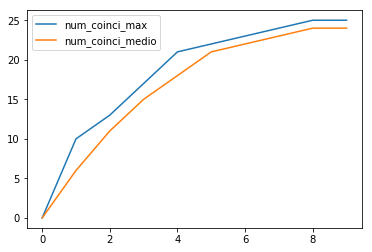

Hay 10 segmentos de información.


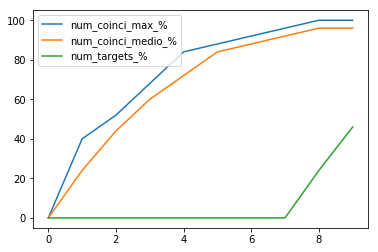

In [1060]:
ImprimirGraficas()